### Import

In [288]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

### Data

In [234]:
train_df = pd.read_csv("intents_train.csv")
test_df = pd.read_csv("intents_test.csv")

In [235]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

le = LabelEncoder()
train_df['intent_label'] = le.fit_transform(train_df['intent'])
num_classes = len(le.classes_)
y_train = train_df['intent_label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], train_df['intent_label'], test_size=0.2, random_state=42
)

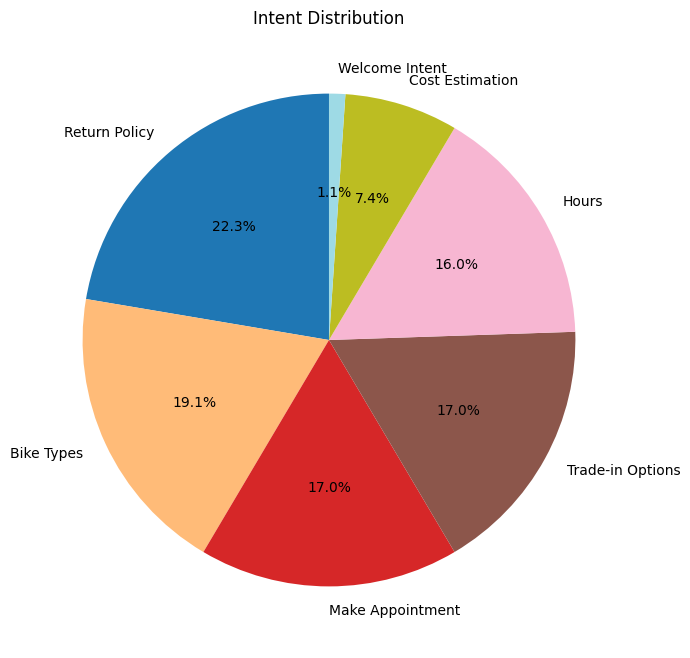

In [236]:
plt.figure(figsize=(12,8))
train_df['intent'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20'
)
plt.ylabel("")
plt.title("Intent Distribution")
plt.show()

### RNN

In [245]:
tokenizer_rnn = Tokenizer()
tokenizer_rnn.fit_on_texts(train_texts)

X_train_seq = tokenizer_rnn.texts_to_sequences(train_texts)
X_val_seq = tokenizer_rnn.texts_to_sequences(val_texts)
X_test_seq = tokenizer_rnn.texts_to_sequences(test_df['text'])

max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

y_train = np.array(train_labels)
y_val = np.array(val_labels)
vocab_size = len(tokenizer_rnn.word_index) + 1
embedding_dim = 100

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.2030 - loss: 1.9311 - val_accuracy: 0.1579 - val_loss: 1.8651
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2251 - loss: 1.8602 - val_accuracy: 0.1579 - val_loss: 1.8098
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3925 - loss: 1.7030 - val_accuracy: 0.3684 - val_loss: 1.7707
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4356 - loss: 1.6245 - val_accuracy: 0.2632 - val_loss: 1.7416
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5301 - loss: 1.5218 - val_accuracy: 0.3684 - val_loss: 1.6957
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5554 - loss: 1.3880 - val_accuracy: 0.3684 - val_loss: 1.6381
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5743 - loss: 1.3610 - val_accuracy: 0.3684 - val_loss: 1.5463
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6765 - loss: 1.1629 - val_accuracy: 0.4211 - val_loss: 1.4701
Epoch 9/25

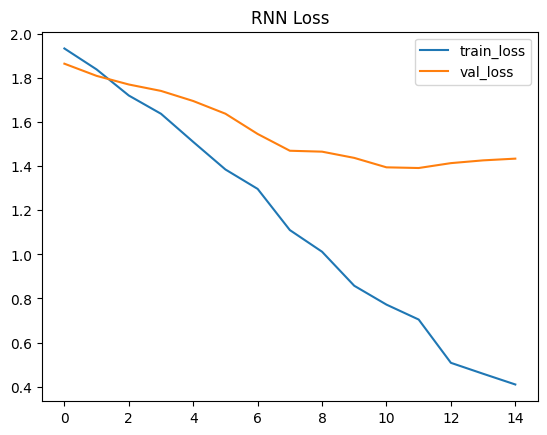

In [246]:
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation='softmax')
])
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=16,
    callbacks=[early_stop],
  )

rnn_pred_prob = rnn_model.predict(X_test_pad)
rnn_pred_labels = np.argmax(rnn_pred_prob, axis=1)
rnn_conf = np.max(rnn_pred_prob, axis=1)

plt.plot(rnn_history.history['loss'], label='train_loss')
plt.plot(rnn_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("RNN Loss")
plt.show()

In [286]:
rnn_model.save("rnn_intent_model.h5")

### LSTM

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.1680 - loss: 1.9422 - val_accuracy: 0.2632 - val_loss: 1.9008
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.2024 - loss: 1.8962 - val_accuracy: 0.2632 - val_loss: 1.8679
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.2995 - loss: 1.8492 - val_accuracy: 0.5263 - val_loss: 1.8318
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3137 - loss: 1.8148 - val_accuracy: 0.5263 - val_loss: 1.8072
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.4006 - loss: 1.7633 - val_accuracy: 0.3158 - val_loss: 1.8053
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3361 - loss: 1.7187 - val_accuracy: 0.2632 - val_loss: 1.8010
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3925 - loss: 1.7163 - val_accuracy: 0.2632 - val_loss: 1.7838
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3115 - loss: 1.7429 - val_accuracy: 0.2632 - val_loss: 1.7484
Epo

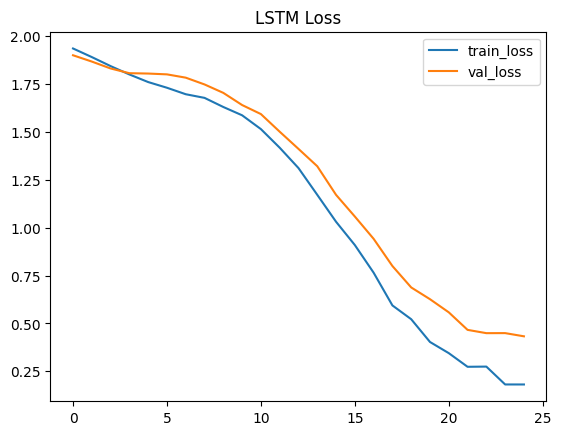

In [257]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=16,
    callbacks=[early_stop]
)

lstm_pred_prob = lstm_model.predict(X_test_pad)
lstm_pred_labels = np.argmax(lstm_pred_prob, axis=1)
lstm_conf = np.max(lstm_pred_prob, axis=1)

plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("LSTM Loss")
plt.show()

In [287]:
lstm_model.save("lstm_intent_model.h5")

### BERT

In [276]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = bert_tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)
test_encodings = bert_tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=64)

class IntentDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = {k: torch.tensor(v) for k,v in encodings.items()}
        self.labels = torch.tensor(labels) if labels is not None else None

    def __len__(self):
        return len(next(iter(self.encodings.values())))

    def __getitem__(self, idx):
        item = {k: v[idx] for k,v in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

train_dataset = IntentDataset(train_encodings, train_labels.tolist())
val_dataset = IntentDataset(val_encodings, val_labels.tolist())
test_dataset = IntentDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [277]:
bert_model.train()
for epoch in range(15):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1 | Loss: 1.8397
Epoch 2 | Loss: 1.7348
Epoch 3 | Loss: 1.6069
Epoch 4 | Loss: 1.5100
Epoch 5 | Loss: 1.3831
Epoch 6 | Loss: 1.3048
Epoch 7 | Loss: 1.1635
Epoch 8 | Loss: 1.0608
Epoch 9 | Loss: 0.8941
Epoch 10 | Loss: 0.8230
Epoch 11 | Loss: 0.6895
Epoch 12 | Loss: 0.6135
Epoch 13 | Loss: 0.5322
Epoch 14 | Loss: 0.4446
Epoch 15 | Loss: 0.3582


In [278]:
bert_model.eval()
bert_preds, bert_conf = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        bert_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        bert_conf.extend(probs.max(dim=1).values.cpu().numpy())

In [290]:
with open("tokenizer_rnn.pkl", "wb") as f:
    pickle.dump(tokenizer_rnn, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

bert_model.save_pretrained("bert_intent_model")
bert_tokenizer.save_pretrained("bert_tokenizer")

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

### Results

In [285]:
thresholds = {'rnn': 0.3, 'lstm': 0.4, 'bert': 0.3}

test_df['rnn_intent'] = [le.inverse_transform([p])[0] if c>thresholds['rnn'] else "Fallback Intent"
                          for p,c in zip(rnn_pred_labels, rnn_conf)]
test_df['lstm_intent'] = [le.inverse_transform([p])[0] if c>thresholds['lstm'] else "Fallback Intent"
                           for p,c in zip(lstm_pred_labels, lstm_conf)]
test_df['bert_intent'] = [le.inverse_transform([p])[0] if c>thresholds['bert'] else "Fallback Intent"
                           for p,c in zip(bert_preds, bert_conf)]

test_df['rnn_conf'] = rnn_conf
test_df['lstm_conf'] = lstm_conf
test_df['bert_conf'] = bert_conf

test_df

,text,rnn_intent,lstm_intent,bert_intent,rnn_conf,lstm_conf,bert_conf
0,do i need to replace my helmet,Return Policy,Make Appointment,Trade-in Options,0.636122,0.623480,0.544880
1,my bike was stolen what should i do,Hours,Trade-in Options,Trade-in Options,0.396236,0.811469,0.432840
2,what types or choices of bikes do i have in yo...,Bike Types,Bike Types,Bike Types,0.791038,0.894324,0.810320
3,do you rent bikes,Trade-in Options,Trade-in Options,Trade-in Options,0.426347,0.558842,0.681499
4,im a student and im doing a project,Bike Types,Bike Types,Fallback Intent,0.334560,0.592374,0.286716
5,can i bring my dog into your shop,Make Appointment,Make Appointment,Trade-in Options,0.388788,0.747983,0.534092
6,do you match prices,Fallback Intent,Trade-in Options,Return Policy,0.258948,0.457015,0.507945
7,can i get an appointment tomorrow,Make Appointment,Make Appointment,Make Appointment,0.558309,0.779377,0.482748
8,how much to repair my bike,Cost Estimation,Cost Estimation,Cost Estimation,0.446696,0.742706,0.458234
9,how do i know what size tiretube i need,Cost Estimation,Return Policy,Trade-in Options,0.441427,0.969987,0.374080


In [294]:
test_df.to_csv("intents.csv", index=False)